# Analysis of Features

In [25]:
# Importing necessary libraries
import dython
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr
from statsmodels.formula.api import ols

In [26]:
# Reading in relevant data
relative_dir = "../data/curated/"
mapping = pd.read_csv(f"{relative_dir}sa2_postcode_mapping_2021.csv")
census = pd.read_csv(f"{relative_dir}census_data.csv")

properties = pd.read_csv(f"{relative_dir}categorised_distances.csv", index_col=0)
properties["Postcode"] = properties["Postcode"].astype(str)

<h3> Preparation for feature analysis </h3>

In [27]:
# Add mapping 
mapping["postcode_2021"] = mapping["postcode_2021"].astype(str)
properties = pd.merge(properties, mapping, left_on="Postcode", right_on="postcode_2021").drop("postcode_2021", axis=1)

In [28]:
# Add census data
census = census[["sa2_2021", "Tot_persons_C21_P", "Med_mortg_rep_mon_C2021", "Med_person_inc_we_C2021", "Med_rent_weekly_C2021", "Med_tot_hh_inc_wee_C2021", "Average_hh_size_C2021"]]
census["sa2_2021"] = census["sa2_2021"].astype(str)

properties["sa2_2021"] = properties["sa2_2021"].astype(str)
properties = pd.merge(properties, census, left_on='sa2_2021', right_on='sa2_2021')

## Rental cost distribution

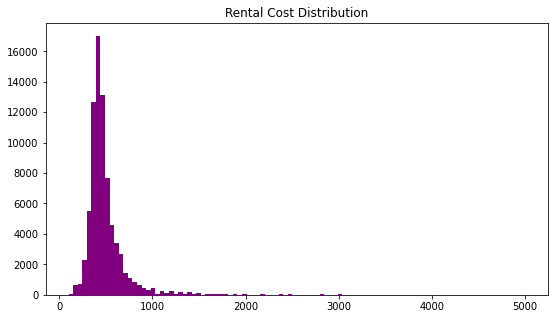

In [24]:
plt.figure(figsize = (9, 5))
plt.title("Rental Cost Distribution")
plt.hist(properties["Cost"], bins=100, color="purple")
plt.savefig("../plots/cost_distribution.jpg")
plt.show()

## Continuous Data Correlations
*Note:* We treat the ordinal features as continuous in order to keep ordering information.

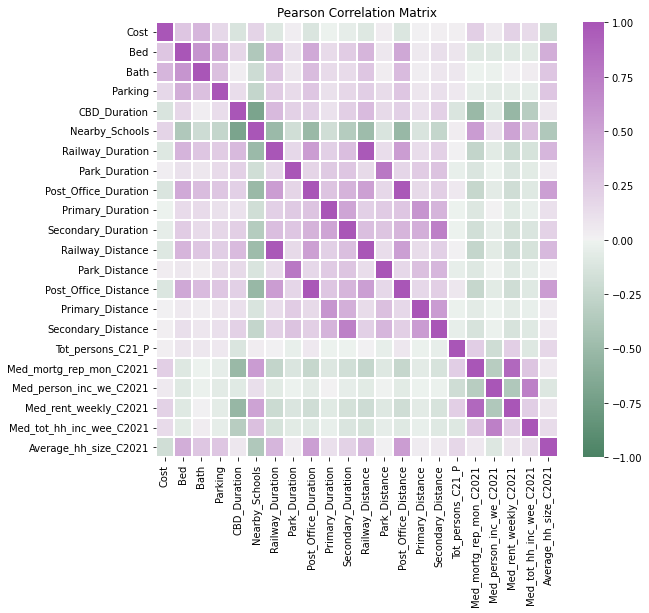

In [7]:
corrmat = properties.corr(method="pearson")
f, ax = plt.subplots(figsize =(9, 8))
colours = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# Possible colours: "coolwarm", "vlag"
sns.heatmap(corrmat, ax = ax, cmap=colours, linewidths = 0.1, center=0, vmin=-1)
plt.title("Pearson Correlation Matrix")
plt.savefig("../plots/correlation.jpg")
plt.show()

Find the most correlated features with rental cost of property.

In [29]:
sorted_mat = corrmat.unstack().sort_values()

# Reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:"correlation"}, axis=1, inplace=True)
df["Index"] = df.index
df = pd.concat(
        [df.drop("Index", axis=1), 
        df["Index"].apply(pd.Series)]
    , axis=1)

# Output correlation list
cost_correlations = pd.DataFrame(df[df[0] == "Cost"]["correlation"])
cost_correlations["abs_corr"] = abs(cost_correlations["correlation"])
cost_correlations.sort_values(by="abs_corr", ascending=False)

correlation  abs_corr
Cost Cost                         1.000000  1.000000
     Bath                         0.376656  0.376656
     Bed                          0.275247  0.275247
     Med_mortg_rep_mon_C2021      0.219289  0.219289
     Med_rent_weekly_C2021        0.195383  0.195383
     Nearby_Schools               0.192550  0.192550
     Average_hh_size_C2021       -0.186988  0.186988
     Parking                      0.158256  0.158256
     Med_tot_hh_inc_wee_C2021     0.141837  0.141837
     CBD_Duration                -0.130048  0.130048
     Post_Office_Duration        -0.118348  0.118348
     Post_Office_Distance        -0.113531  0.113531
     Railway_Duration            -0.100928  0.100928
     Railway_Distance            -0.094452  0.094452
     Med_person_inc_we_C2021      0.051996  0.051996
     Secondary_Duration          -0.047820  0.047820
     Park_Distance                0.036797  0.036797
     Park_Duration                0.030592  0.030592
     Tot_persons_C21_P            0.020569  0.020569
     Secondary_Distance           0.020156  0.020156
     Primary_Distance             0.010185  0.010185
     Primary_Duration            -0.008771  0.008771

## Continuous and Categorical Data Correlations

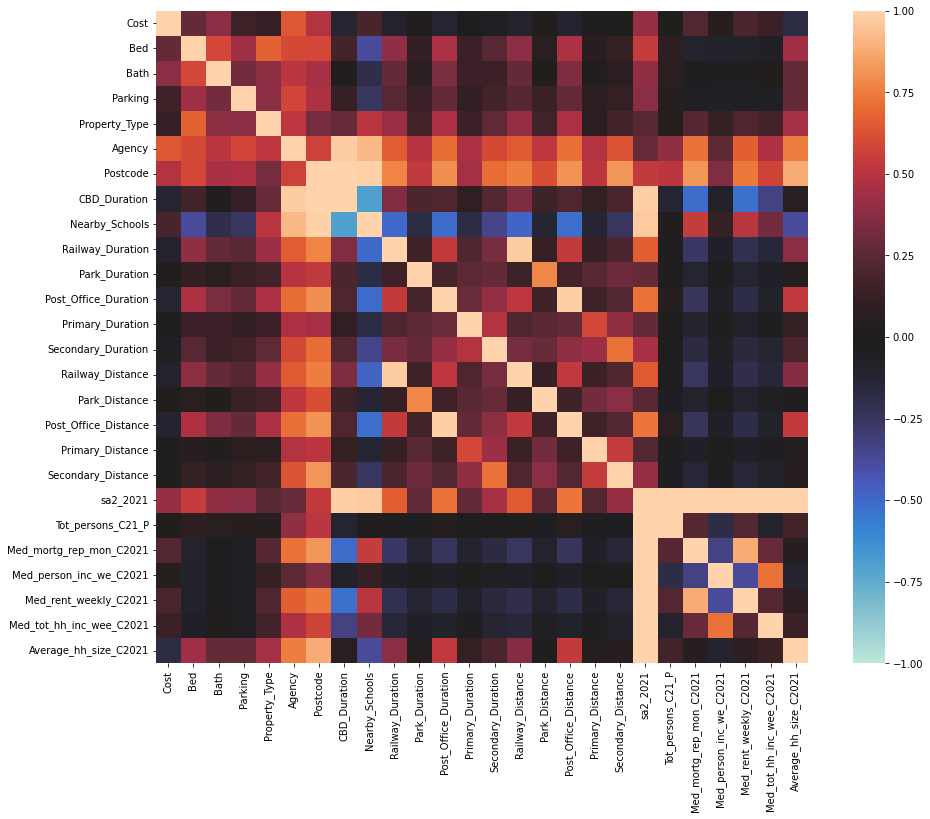

In [31]:
# Get initial correlation matrix
exclusions = ["Name", "Coordinates"]
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False, filename='../plots/corr_matrix.jpg', figsize=(16,12))

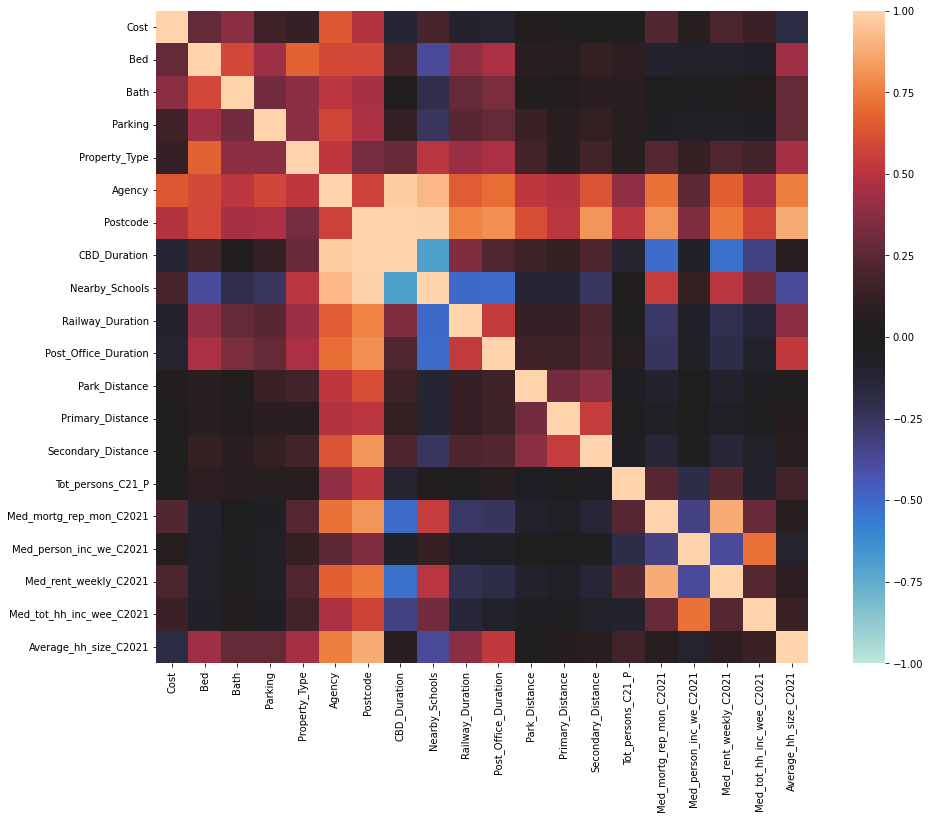

In [32]:
exclusions = ["Name", "Coordinates", "sa2_2021", "Railway_Distance", "Post_Office_Distance", "Park_Duration", "Secondary_Duration", "Primary_Duration"]
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False, filename='../plots/corr_matrix_filtered.jpg', figsize=(16,12))

In [34]:
sorted_mat = corr_mat["corr"].unstack().sort_values()

# Reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:"correlation"}, axis=1, inplace=True)
df["Index"] = df.index
df = pd.concat(
        [df.drop("Index", axis=1), 
        df["Index"].apply(pd.Series)]
    , axis=1)

# Output correlation list
cost_correlations = pd.DataFrame(df[df[0] == "Cost"]["correlation"])
cost_correlations["abs_corr"] = abs(cost_correlations["correlation"])
cost_correlations = cost_correlations.sort_values(by="abs_corr", ascending=False)

# Remove multi-level indexing
cost_correlations.index = cost_correlations.index.droplevel(0)

cost_correlations = cost_correlations.drop("Cost")
cost_correlations

,correlation,abs_corr
Agency,0.642022,0.642022
Postcode,0.485299,0.485299
Bath,0.376656,0.376656
Bed,0.275247,0.275247
Med_mortg_rep_mon_C2021,0.219289,0.219289
Med_rent_weekly_C2021,0.195383,0.195383
Nearby_Schools,0.192550,0.192550
Average_hh_size_C2021,-0.186988,0.186988
Parking,0.158256,0.158256
Med_tot_hh_inc_wee_C2021,0.141837,0.141837


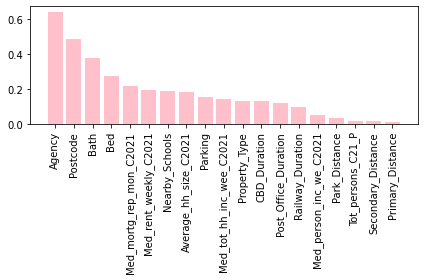

In [38]:
plt.bar(cost_correlations.index, cost_correlations.abs_corr, color='pink')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../plots/correlation_chart.jpg')

# Categorical ANOVAs

In [23]:
# Test for relationship with categorical variables using one-way ANOVA
categoricals = ["Postcode", "Property_Type", "Agency"]

for c in categoricals:
    model = ols("Cost ~ "+c, data = properties).fit() # ordinary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq       mean_sq          F  PR(>F)
Postcode    408.0  1.053144e+09  2.581236e+06  58.301687     0.0
Residual  77213.0  3.418511e+09  4.427378e+04        NaN     NaN
                    df        sum_sq       mean_sq           F         PR(>F)
Property_Type      9.0  7.762017e+07  8.624464e+06  152.334208  5.302198e-287
Residual       77612.0  4.394035e+09  5.661541e+04         NaN            NaN
               df        sum_sq       mean_sq          F  PR(>F)
Agency     1384.0  1.843183e+09  1.331780e+06  38.627352     0.0
Residual  76237.0  2.628472e+09  3.447764e+04        NaN     NaN


All p values are less than 0.05 so all attributes are significant.